This project's main goal was to utilize a CNN based model to analyze song audio files converted to mel spectrograms and see if it could classify/predict the album the song was released on with reasonable accuracy. I focused on a single artist "Green Day" and 7 albums to build a framework I intend to build upon over time. Green day was used since I already had the audiofiles accessable.

The first step involved generating enough data to train a CNN model.  I decided to split the songs into 15 segments per song. 10 of those segments were used for the initial train and test set. the other 5 were set aside to further evaluate the model once it was saved and reloaded. 

A potential issue in generating the data was how the songs were split into 15 equal segments. The impact of song length on model performance was not fully explored or corrected. This will be investigated more in the future. However, its worth noting that song length did seem to have an impact as the album American Idiot has 2 unusually long songs. when initial testing the model including american idiot in the test data produced much lower accuracy after traing than when it was left out. as a quick fix, Jesus of Suburbia was split into 5 parts since it was written with 5 distinct and subtitled section in the song. Homecoming was removed as an outlier due to its length and the song section being written and sung by each member of the group. however a more robust method of splitting songs into multiple parts needs to be developed.

Features and labels were extracted from the song segments during the conversion to mel spectrograms. the data was preprocesed to a usable structure the CNN could interpret. A confusion matrix, accuracy plot over epochs, and accuracy calculation were generated after traning the model. the model was save and reloaded and 5 new song segments were preprocessed in the same manner as the training/test data and the model correctly predicted the album labels for the song segment with a 78% success rate. 

This model was an exercise and more work can be done to improve performance and capabilities which I will implement over time.



In [ ]:
import os
from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError

# Function to split an audio file into 15 segments and distribute them between training and evaluation folders
def split_audio(file_path, train_folder, eval_folder):
    # Get base name and extension of file
    file_name, file_extension = os.path.splitext(os.path.basename(file_path))

    try:
        # Load audio file with format explicitly specified
        audio = AudioSegment.from_file(file_path, format=file_extension[1:])
        
        # Calculate segment duration
        segment_duration = len(audio) // 15  # Divide into 15 segments.placing 5 segements in separate folder to test model after training/saving
        
        # Create output folders if they don't exist
        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(eval_folder, exist_ok=True)
        
        # Split and export segments: first 10 for training, last 5 for evaluation
        for i in range(15):
            start_time = i * segment_duration
            end_time = start_time + segment_duration
            
            # Export segment with the same file extension
            segment = audio[start_time:end_time]
            
            if i < 10:
                # Save first 10 segments to the training folder
                output_file = os.path.join(train_folder, f"{file_name}_segment_{i+1}{file_extension}")
            else:
                # Save last 5 segments to the evaluation folder
                output_file = os.path.join(eval_folder, f"{file_name}_segment_{i+1}{file_extension}")
                
            segment.export(output_file, format=file_extension[1:])  # Remove the dot from the extension
            print(f"Exported {output_file}")
    except CouldntDecodeError:
        print(f"Could not decode {file_path}, skipping file.")

# Base directory containing subfolders with audio files
base_dir = 'C://Users/morni/Side Projects/Green Day'

# Define the output directories inside the base directory
train_folder = os.path.join(base_dir, 'output_segments', 'train')
eval_folder = os.path.join(base_dir, 'output_segments', 'eval')

# Walk through all subdirectories in the base directory, skipping 'output_segments'
for root, dirs, files in os.walk(base_dir):
    # Skip processing the 'output_segments' folder
    dirs[:] = [d for d in dirs if d != 'output_segments']
    
    for file in files:
        if file.endswith('.mp3') or file.endswith('.wav'):  # Adjust for more formats if needed
            # Get the full path of the audio file
            file_path = os.path.join(root, file)
            
            # Create an output folder for each subfolder for both training and evaluation
            relative_path = os.path.relpath(root, base_dir)
            subfolder_train = os.path.join(train_folder, relative_path)
            subfolder_eval = os.path.join(eval_folder, relative_path)
            
            # Split the audio file and save the segments
            split_audio(file_path, subfolder_train, subfolder_eval)

Epoch 1/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2114 - loss: 3.0399 - val_accuracy: 0.1122 - val_loss: 24.0761
Epoch 2/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3505 - loss: 1.6427 - val_accuracy: 0.1276 - val_loss: 3.7857
Epoch 3/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5291 - loss: 1.2311 - val_accuracy: 0.1582 - val_loss: 2.9696
Epoch 4/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6598 - loss: 0.8937 - val_accuracy: 0.1786 - val_loss: 2.8246
Epoch 5/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7764 - loss: 0.6460 - val_accuracy: 0.1939 - val_loss: 2.4950
Epoch 6/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8452 - loss: 0.4702 - val_accuracy: 0.1990 - val_loss: 1.9104
Epoch 7/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8727 - loss: 0.3787 - val_accuracy: 0.2092 - val_loss: 2.1022
Epoch 8/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8971 - loss: 0.2907 - val_accuracy: 0.6173 - val_loss

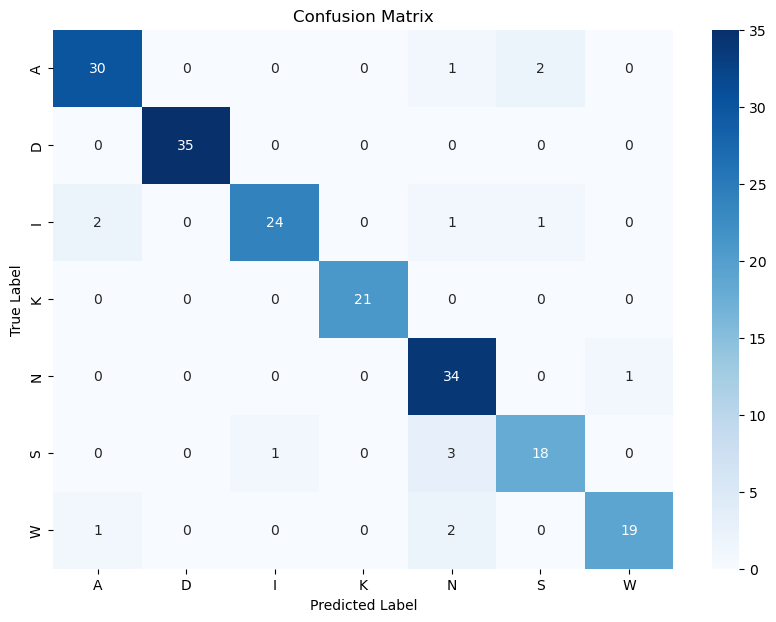

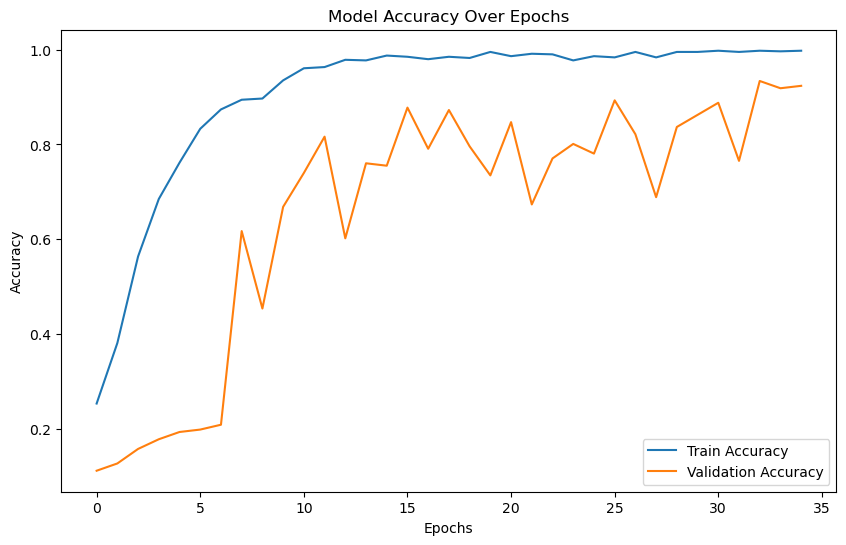

In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization

# Initialize lists to store features and labels
features = []
labels = []

base_dir = base_dir = 'C://Users/morni/Side Projects/Green Day/output_segments/train'

# Function to extract mel spectrogram and MFCC from audio file
def extract_features(file, max_len=128, n_mfcc=13, hop_length=1024):
    y, sr = librosa.load(file, sr=22050)
    
    # Extract Mel spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=hop_length)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    
    # Extract MFCC using the same hop length
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    
    # Ensure all features have the same length
    if mel_spect_db.shape[1] > max_len:
        mel_spect_db = mel_spect_db[:, :max_len]
    else:
        pad_width = max_len - mel_spect_db.shape[1]
        mel_spect_db = np.pad(mel_spect_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    if mfccs.shape[1] > max_len:
        mfccs = mfccs[:, :max_len]
    else:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    # Concatenate Mel spectrogram and MFCCs along the first axis
    combined_features = np.concatenate((mel_spect_db, mfccs), axis=0)
    
    return combined_features

# Loop through each folder in the base directory
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    if os.path.isdir(folder_path):
        # Loop through each file in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.mp3'):
                file_path = os.path.join(folder_path, file_name)
                
                # Extract combined features (Mel spectrogram + MFCCs)
                combined_features = extract_features(file_path)
                features.append(combined_features)
                
                # Add the label (first letter of folder name as label capitalized)
                labels.append(folder_name[0].upper())

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

# Encode the labels
unique_labels = np.unique(y)
label_map = {label: i for i, label in enumerate(unique_labels)}
y_encoded = np.array([label_map[label] for label in y])
y_encoded = to_categorical(y_encoded, num_classes=len(unique_labels))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=432)

# Add a channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Add an Input layer
model = models.Sequential()
model.add(layers.Input(shape=(141, 128, 1)))  # Specify input shape (141 = 128 Mel bands + 13 MFCCs)

# First Conv Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Conv Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# third Conv Layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and add Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))  # Prevent overfitting
model.add(layers.Dense(len(unique_labels), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=35, batch_size=48, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [3]:
model.save('C://Users/morni/Side Projects/Green Day/GD_Class_mdl_4.keras')

In [5]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# Initialize lists to store features and labels
features = []
labels = []

# Define base directory where your .wav files are located
base_dir = 'C://Users/morni/Side Projects/Green Day/output_segments/eval'

# Function to extract mel spectrogram and MFCC from audio file
def extract_features(file, max_len=128, n_mfcc=13, hop_length=1024):
    y, sr = librosa.load(file, sr=22050)
    
    # Extract Mel spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=hop_length)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    
    # Extract MFCC using the same hop length
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    
    # Ensure all features have the same length
    if mel_spect_db.shape[1] > max_len:
        mel_spect_db = mel_spect_db[:, :max_len]
    else:
        pad_width = max_len - mel_spect_db.shape[1]
        mel_spect_db = np.pad(mel_spect_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    if mfccs.shape[1] > max_len:
        mfccs = mfccs[:, :max_len]
    else:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    # Concatenate Mel spectrogram and MFCCs along the first axis
    features = np.concatenate((mel_spect_db, mfccs), axis=0)
    
    return features

# Loop through each folder in the base directory
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    if os.path.isdir(folder_path):
        # Assign the folder name (or some characteristic) as the label
        label = folder_name[0].upper()  # E.g., first letter of folder name as label
        
        # Loop through each file in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.mp3'):
                file_path = os.path.join(folder_path, file_name)
                
                # Extract combined features (Mel spectrogram + MFCCs)
                combined_features = extract_features(file_path)
                features.append(combined_features)
                
                # Append the corresponding label for each file
                labels.append(label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

# Encode the labels
unique_labels = np.unique(y)
label_map = {label: i for i, label in enumerate(unique_labels)}
y_encoded = np.array([label_map[label] for label in y])
y_encoded = to_categorical(y_encoded, num_classes=len(unique_labels))

# Add a channel dimension to the features for CNN input (batch, height, width, channel)
X = X[..., np.newaxis]

# Load the saved model
loaded_model = tf.keras.models.load_model('C://Users/morni/Side Projects/Green Day/GD_Class_mdl_4.keras')

# Use the model to predict
predictions = loaded_model.predict(X)

# Get the predicted class labels
predicted_classes = np.argmax(predictions, axis=1)

# Map predicted class indices back to original labels
predicted_labels = [unique_labels[i] for i in predicted_classes]

# Initialize a counter for correct predictions
correct_predictions = 0

# Print the actual labels and the predicted labels
for i, predicted_label in enumerate(predicted_labels):
    actual_label = y[i]  # Get the actual label from the original labels array
    print(f"Sample {i}: Actual label: {actual_label}, Predicted label: {predicted_label}")
    
    # Check if the prediction is correct
    if predicted_label == actual_label:
        correct_predictions += 1

# Calculate percent accuracy
total_samples = len(predicted_labels)
accuracy = (correct_predictions / total_samples) * 100
print(f"Accuracy: {accuracy:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step
Sample 0: Actual label: A, Predicted label: A
Sample 1: Actual label: A, Predicted label: A
Sample 2: Actual label: A, Predicted label: A
Sample 3: Actual label: A, Predicted label: A
Sample 4: Actual label: A, Predicted label: A
Sample 5: Actual label: A, Predicted label: A
Sample 6: Actual label: A, Predicted label: A
Sample 7: Actual label: A, Predicted label: A
Sample 8: Actual label: A, Predicted label: A
Sample 9: Actual label: A, Predicted label: A
Sample 10: Actual label: A, Predicted label: A
Sample 11: Actual label: A, Predicted label: A
Sample 12: Actual label: A, Predicted label: A
Sample 13: Actual label: A, Predicted label: A
Sample 14: Actual label: A, Predicted label: A
Sample 15: Actual label: A, Predicted label: A
Sample 16: Actual label: A, Predicted label: A
Sample 17: Actual label: A, Predicted label: A
Sample 18: Actual label: A, Predicted label: A
Sample 19: Actual label: A, Predicted label: A
Sample 20: Actual label: A, P